# Evaluation in terms of spherical harmonics
This notebook contains the computation necessary to transform mascon models and geodesyNETs model into normalized Stokes coefficients. We use the following formal definition for the description of the gravitational potential (Tricarico 2013, Yoder 1995):

$$
U(r, \theta, \phi) = \frac \mu r \sum_{l=0}^{l=\infty}\sum_{m=0}^{m=l}\left(\frac {r_0}r\right)P_{lm}(cos\theta) \cdot\\
\cdot \left( C_{lm}\cos m\phi + S_{lm} \sin m\phi \right)
$$

where the Stokes coefficients relate to the body density via the formulas:


and

$$
C_{lm} = \frac{(2-\delta_{m,0})}{M}\frac{(l-m)!}{(l+m)!} \int_V \rho \left(\frac{r}{r_0} \right)^l \cdot\\
\cdot P_{lm}(\cos\theta)\cos m\phi dV
$$

and

$$
S_{lm} = \frac{(2-\delta_{m,0})}{M}\frac{(l-m)!}{(l+m)!} \int_V \rho \left(\frac{r}{r_0} \right)^l \cdot\\
\cdot P_{lm}(\cos\theta)\sin m\phi dV
$$

We also use the normalization factor $N_{lm}$ defined as:

$$
N_{lm} = \sqrt{\frac{(l+m)!}{(2-\delta_{m,0})(2l+1)(l-m)!} }
$$

so that our normalized Stokes coefficients are $\left\{\tilde C_{m,l}, \tilde
S_{m,l}\right\} = \left\{C_{m,l}, S_{m,l}\right\} N_{lm}$


In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import scipy
import pickle as pk
import os
import torchquad as tquad
tquad.set_log_level("CRITICAL")

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

/home/dario/.local/lib/python3.9/site-packages/pyvista/themes.py:123: PyvistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyvistaDeprecationWarning)
00:00:55|TQ-INFO| Initializing torchquad.


Will use device  cpu


/home/dario/Develop/geodesyNets/gravann/_utils.py:80: UserWarning: Error enabling CUDA. cuda.is_available() returned False. CPU will be used.
  warnings.warn(


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
# We load the ground truth (a mascon model of some body)
with open("mascons/Eros.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = mascon_points
mascon_masses = mascon_masses

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

Name:  Eros
Number of mascons:  39554
Total mass:  1.0000000000000102


<IPython.core.display.Javascript object>


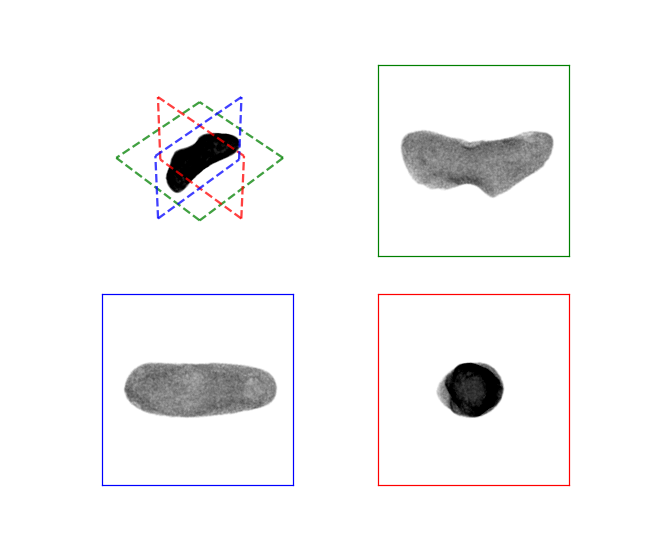

In [3]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses)

# Computing the Stokes coefficients (Ground Truth)


In [4]:
# Units of Length (this is Eros) (depend on how the the mascon model was created .... )
L  = 20413.864850997925
R0 = 16000/L


In [5]:
l=7
m=7
stokesC, stokesS = gravann.mascon2stokes(mascon_points, mascon_masses, R0, l, m)

In [6]:
stokesC

array([[ 1.00000000e+00, -4.04606463e-18, -5.28065572e-02,
        -1.42748628e-03,  1.30440328e-02,  6.56611293e-04,
        -4.92049480e-03, -3.07252443e-04],
       [ 0.00000000e+00,  6.29811348e-17,  6.24686799e-21,
         3.38521252e-03, -1.52065515e-04, -2.49920040e-03,
        -3.47865092e-05,  1.65976108e-03],
       [ 0.00000000e+00,  0.00000000e+00,  8.76621842e-02,
         1.91022046e-03, -1.81465064e-02, -9.07861145e-04,
         6.58042563e-03,  4.37216442e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -3.32882375e-03, -1.90902666e-04,  2.33863720e-03,
         1.58542027e-04, -1.45853166e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.95024228e-02,  8.06522172e-04,
        -5.53179478e-03, -4.40970840e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.62036230e-03,
        -2.84645620e-04,  1.11117734e-03],
       [ 0.00000000e+00,  0.000000

In [7]:
stokesS

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  1.34332014e-17, -9.15380830e-17,
         4.03389207e-03,  1.16786885e-04, -1.66474372e-03,
        -7.56881388e-05,  8.04475233e-04],
       [ 0.00000000e+00,  0.00000000e+00, -5.10262177e-17,
        -1.07051280e-04, -1.27802040e-03,  1.03248071e-04,
         9.76524148e-04, -7.01105901e-05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.57537451e-02, -2.47991494e-04,  5.34620441e-03,
         2.42381290e-04, -2.42416256e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  3.46458959e-03, -2.59750640e-04,
        -1.96939531e-03,  1.28771562e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -1.15893462e-02,
        -4.11961080e-04,  4.14767560e-03],
       [ 0.00000000e+00,  0.000000

# Computing the Stokes coefficients from a geodesyNET

In [8]:
# Vectorized version of cartesian to spherical coordinates (radius, colatitude (0,pi), longitude  (0,2pi))
def cart2spherical(x):
    r = torch.norm(x, dim=1).view(-1,1)
    theta = torch.arccos(x[:,2].view(-1,1)/r)
    phi = np.arctan2(x[:,1], x[:,0]).view(-1,1)
    phi[phi<0] = phi[phi<0] + 2*torch.pi
    return torch.concat((r,theta,phi), dim=1)

# Integrand to compute the mass
def mass(x):
    return model(x)

# Integrand to compute the C Stokes coefficents (normalization and other factors not included)
def Clm(x, l, m):
    sph = cart2spherical(x)
    retval = model(x)
    retval = retval * (sph[:,0].view(-1,1)/R0)**l
    retval = retval * P[l][m](torch.cos(sph[:,1].view(-1,1)))
    retval = retval * torch.cos(m*sph[:,2].view(-1,1))
    return retval

# Integrand to compute the S Stokes coefficents (normalization and other factors not included)
def Slm(x, l, m):
    sph = cart2spherical(x)
    retval = model(x)
    retval = retval * (sph[:,0].view(-1,1)/R0)**l
    retval = retval * P[l][m](torch.cos(sph[:,1].view(-1,1)))
    retval = retval * torch.sin(m*sph[:,2].view(-1,1))
    return retval

# Normalization and factors to get the normalized Stokes
def normalization(n,m):
    if m==0:
        delta=1.
    else:
        delta=0
    retval = (2.-delta)*np.math.factorial(l-m)/np.math.factorial(l+m)
    retval = retval * np.sqrt(1./(2.-delta)/np.math.factorial(l-m)/(2.*l+1.)*np.math.factorial(l+m))
    return retval

# Constructs the vectorized Legendre associated polynomials as lambda funcions 
def legendre_factory(n=16):
    P = dict()
    for i in range(n+1):
        P[i] = dict()
    P[0][0] = lambda x: torch.ones(len(x),1)
    # First we compute all the associated legendre polynomials with l=m. (0,0), (1,1), (2,2), ....
    for l in range(n):
        P[l+1][l+1] = lambda x, l=l: -(2*l+1) * torch.sqrt(1-x**2) * P[l][l](x)
    # Then we compute the ones with l+1,l. (1,0), (2,1), (3,2), ....
    for l in range(n):
        P[l+1][l] = lambda x, l=l: (2*l+1) * x * P[l][l](x)
    # Then all the rest
    for m in range(16+1):
        for l in range(m+1,16):
            P[l+1][m] = lambda x, l=l, m=m: ((2*l+1) * x * P[l][m](x) - (l+m)*P[l-1][m](x))/(l-m+1)
    return P

## We load a trained model of Eros

In [9]:
# Encoding: direct encoding (i.e. feeding the network directly with the Cartesian coordinates in the unit hypercube)
# was found to work well in most cases. But more options are implemented in the module.
encoding = gravann.direct_encoding()

# The model is here a SIREN network (FFNN with sin non linearities and a final absolute value to predict the density)
model = gravann.init_network(encoding, n_neurons=100, model_type="siren", activation = gravann.AbsLayer())
model.load_state_dict(torch.load("models/eros.mdl", map_location=torch.device('cpu')))

<All keys matched successfully>

... and we initialize the quadrature object and the associated Legendre polynomials

In [10]:
# We construct the vecotrized Legendre associated polynomials
P = legendre_factory(16)
# Declare an integrator
quad = tquad.Trapezoid()

... we compute the Asteroid mass from the model (this corresponds to 1/c)

In [11]:
# Compute the function integral
M = quad.integrate(mass,dim=3,N=300000,integration_domain = [[-1,1],[-1,1],[-1,1]])

/home/dario/miniconda3/envs/geodesynet/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1635217160634/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
for l in range(8):
    for m in range(8):
        if m>l:
            continue
        value = quad.integrate(lambda x, l=l, m=m: Clm(x, l, m),dim=3,N=300000,integration_domain = [[-1,1],[-1,1],[-1,1]])
        value = value/M*normalization(l,m)
        print(f"C_{l}{m} {stokesC[m][l]:2.3e} {value:2.3e}")

C_00 1.000e+00 1.000e+00
C_10 -4.046e-18 -3.142e-05
C_11 6.298e-17 -1.266e-04
C_20 -5.281e-02 -5.289e-02
C_21 6.247e-21 3.666e-05
C_22 8.766e-02 8.772e-02
C_30 -1.427e-03 -1.452e-03
C_31 3.385e-03 3.369e-03
C_32 1.910e-03 1.920e-03
C_33 -3.329e-03 -3.340e-03
C_40 1.304e-02 1.288e-02
C_41 -1.521e-04 -1.604e-04
C_42 -1.815e-02 -1.812e-02
C_43 -1.909e-04 -1.902e-04
C_44 1.950e-02 1.940e-02
C_50 6.566e-04 6.378e-04
C_51 -2.499e-03 -2.503e-03
C_52 -9.079e-04 -9.130e-04
C_53 2.339e-03 2.329e-03
C_54 8.065e-04 6.823e-04
C_55 -2.620e-03 -2.623e-03
C_60 -4.920e-03 -4.844e-03
C_61 -3.479e-05 -5.740e-05
C_62 6.580e-03 6.524e-03
C_63 1.585e-04 1.721e-04
C_64 -5.532e-03 -5.865e-03
C_65 -2.846e-04 -3.057e-04
C_66 4.122e-03 4.083e-03
C_70 -3.073e-04 -9.640e-05
C_71 1.660e-03 1.669e-03
C_72 4.372e-04 3.901e-04
C_73 -1.459e-03 -1.487e-03
C_74 -4.410e-04 -7.604e-04
C_75 1.111e-03 1.164e-03
C_76 4.191e-04 3.030e-04
C_77 -7.388e-04 -7.320e-04


In [13]:
for l in range(8):
    for m in range(8):
        if m>l:
            continue
        value = quad.integrate(lambda x, l=l, m=m: Slm(x, l, m),dim=3,N=300000,integration_domain = [[-1,1],[-1,1],[-1,1]])
        value = value/M*normalization(l,m)
        print(f"S_{l}{m} {stokesS[m][l]:2.3e} {value:2.3e}")

S_00 0.000e+00 0.000e+00
S_10 0.000e+00 0.000e+00
S_11 1.343e-17 -1.415e-05
S_20 0.000e+00 0.000e+00
S_21 -9.154e-17 -3.187e-05
S_22 -5.103e-17 -3.805e-05
S_30 0.000e+00 0.000e+00
S_31 4.034e-03 4.003e-03
S_32 -1.071e-04 -1.107e-04
S_33 -1.575e-02 -1.575e-02
S_40 0.000e+00 0.000e+00
S_41 1.168e-04 1.157e-04
S_42 -1.278e-03 -1.290e-03
S_43 -2.480e-04 -3.195e-04
S_44 3.465e-03 3.452e-03
S_50 0.000e+00 0.000e+00
S_51 -1.665e-03 -1.607e-03
S_52 1.032e-04 1.145e-04
S_53 5.346e-03 5.256e-03
S_54 -2.598e-04 -2.506e-04
S_55 -1.159e-02 -1.158e-02
S_60 0.000e+00 0.000e+00
S_61 -7.569e-05 1.377e-05
S_62 9.765e-04 9.581e-04
S_63 2.424e-04 8.116e-05
S_64 -1.969e-03 -2.045e-03
S_65 -4.120e-04 -4.094e-04
S_66 3.352e-03 3.355e-03
S_70 0.000e+00 0.000e+00
S_71 8.045e-04 7.977e-04
S_72 -7.011e-05 -2.362e-05
S_73 -2.424e-03 -2.290e-03
S_74 1.288e-04 1.818e-04
S_75 4.148e-03 4.186e-03
S_76 -1.389e-04 -8.159e-05
S_77 -7.025e-03 -6.933e-03
